# Snake

In [1]:
# Environments
import environments_fully_observable 
import environments_partially_observable
from environments_fully_observable import OriginalSnakeEnvironment

# Training utilities
import numpy as np
from tqdm import trange
from tqdm import tqdm
from dataclasses import dataclass
from typing import Tuple
from collections import deque

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd

# Seed for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Check for GPU availability (CUDA for Nvidia, MPS for Mac M4)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✅ GPU Found: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ MPS (Metal Performance Shaders) Found: Apple Silicon Acceleration enabled.")
else:
    device = torch.device("cpu")
    print("❌ No GPU Found. Using CPU.")

✅ GPU Found: NVIDIA GeForce RTX 5050 Laptop GPU


## Environment definition

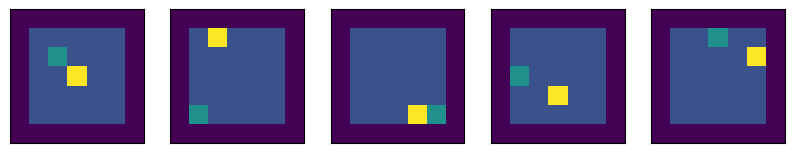

In [2]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e

env_ = get_env()

fig, axs = plt.subplots(1, min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")
    

# Useful for future experiments if we want to change the number of (parallel) boards and their size 
# in the training loop without having to change the environment code

NUM_BOARDS = 256
BOARD_SIZE = 7

# Full Environment wrapper
def make_env(n_boards, board_size):
    return OriginalSnakeEnvironment(n_boards,board_size)

In [3]:
# Safety mask fuction: checks for unsafe moves for all boards
def get_safety_mask(env):
    masks = np.zeros((env.n_boards, 4), dtype=np.float32)
    heads = np.argwhere(env.boards == env.HEAD)
    heads = heads[heads[:, 0].argsort()]

    moves = {0:(1,0), 1:(0,1), 2:(-1,0), 3:(0,-1)}

    for b, hx, hy in heads:
        for a, (dx, dy) in moves.items():
            nx, ny = hx+dx, hy+dy
            if env.boards[b, nx, ny] == env.WALL:
                masks[b, a] = 1.0   # unsafe for wall
    return torch.tensor(masks, device=device)

# Models

## PPO Agent

In [4]:
# Define the PPO Actor-Critic Network
class PPOActorCritic(nn.Module):
    def __init__(self, board_size=7, n_channels=4, n_actions=4):
        super().__init__()

        self.conv1 = nn.Conv2d(n_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.board_size = board_size
        conv_out_dim = 128 * board_size * board_size

        self.fc = nn.Linear(conv_out_dim, 128)
        self.policy_head = nn.Linear(128, n_actions)
        self.value_head = nn.Linear(128, 1)

    def forward(self, x) -> Tuple[torch.Tensor, torch.Tensor]:
        x = x.permute(0, 3, 1, 2)          # (N, H, W, C) -> (N, C, H, W)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc(x))

        logits = self.policy_head(x)
        value = self.value_head(x).squeeze(-1)
        return logits, value

    def act(self, x, mask=None):
        logits, value = self.forward(x)
        if mask is not None:
            logits = logits + mask
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logprob = dist.log_prob(action)
        return action, logprob, value


    def evaluate_actions(self, x, actions):
        logits, values = self.forward(x)
        dist = torch.distributions.Categorical(logits=logits)
        logprobs = dist.log_prob(actions)
        entropy = dist.entropy()
        return logprobs, entropy, values


In [6]:
# Define the Rollout Buffer for PPO
@dataclass
class RolloutBuffer:
    obs: list
    actions: list
    logprobs: list
    rewards: list
    values: list

    def __init__(self):
        self.obs = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.values = []

    def add(self, obs, action, logprob, reward, value):
        # obs, reward, value, logprob, action are numpy or scalars
        self.obs.append(obs)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.rewards.append(reward)
        self.values.append(value)

    def to_tensors(self):
        # conver all to torch tensors
        obs = torch.tensor(np.array(self.obs), dtype=torch.float32, device=device)
        actions = torch.tensor(np.array(self.actions), dtype=torch.long, device=device)
        logprobs = torch.tensor(np.array(self.logprobs), dtype=torch.float32, device=device)
        rewards = torch.tensor(np.array(self.rewards), dtype=torch.float32, device=device)
        values = torch.tensor(np.array(self.values), dtype=torch.float32, device=device)
        return obs, actions, logprobs, rewards, values

# Define the GAE computation
def compute_gae(rewards, values, last_value, gamma=0.99, lam=0.95):
    T, N = rewards.shape
    advantages = torch.zeros(T, N, device=device)
    gae = torch.zeros(N, device=device)

    for t in reversed(range(T)):
        next_value = last_value if t == T - 1 else values[t + 1]
        delta = rewards[t] + gamma * next_value - values[t]
        gae = delta + gamma * lam * gae
        advantages[t] = gae

    returns = advantages + values
    return advantages, returns


In [7]:
# Define the PPO Agent class:
class PPOAgent:
    def __init__(
        self,
        board_size=7,
        n_actions=4,
        lr=4e-4,
        gamma=0.99,
        lam=0.95,
        clip_eps=0.2,
        epochs=4,
        batch_size=1024,
        ent_coef=0.05,   
    ):
        self.gamma = gamma
        self.lam = lam
        self.clip_eps = clip_eps
        self.epochs = epochs
        self.batch_size = batch_size
        self.ent_coef = ent_coef
        self.ent_coef_initial = ent_coef

        self.net = PPOActorCritic(board_size=board_size, n_channels=4, n_actions=n_actions).to(device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)

    def update(self, buffer: RolloutBuffer, last_value):
        # Move last_value to device
        last_value = last_value.to(device)

        obs, actions, old_logprobs, rewards, values = buffer.to_tensors()

        # obs: (T, N, H, W, C)
        T, N = rewards.shape
        obs = obs.view(T * N, *obs.shape[2:])
        actions = actions.view(T * N)
        old_logprobs = old_logprobs.view(T * N)
        rewards = rewards.view(T, N)
        values = values.view(T, N)
        last_value = last_value.view(N)

        advantages, returns = compute_gae(
            rewards, values, last_value,
            gamma=self.gamma, lam=self.lam
        )

        advantages = advantages.view(T * N)
        returns = returns.view(T * N)

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # PPO update
        dataset_size = T * N
        idxs = np.arange(dataset_size)

        total_policy_loss = 0.0
        total_value_loss = 0.0
        total_entropy = 0.0
        total_loss = 0.0
        batches = 0

        for _ in range(self.epochs):
            np.random.shuffle(idxs)
            for start in range(0, dataset_size, self.batch_size):
                end = start + self.batch_size
                batch_idx = idxs[start:end]

                # we select the batch and compute the losses
                batch_obs = obs[batch_idx]
                batch_actions = actions[batch_idx]
                batch_old_logprobs = old_logprobs[batch_idx]
                batch_adv = advantages[batch_idx]
                batch_returns = returns[batch_idx]

                logprobs, entropy, values_pred = self.net.evaluate_actions(batch_obs, batch_actions)

                ratio = torch.exp(logprobs - batch_old_logprobs)
                surr1 = ratio * batch_adv
                surr2 = torch.clamp(ratio, 1.0 - self.clip_eps, 1.0 + self.clip_eps) * batch_adv
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = F.mse_loss(values_pred, batch_returns)

                loss = policy_loss + 0.5 * value_loss - self.ent_coef * entropy.mean()

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), 0.5)
                self.optimizer.step()

                # accumulate 
                total_policy_loss += policy_loss.item() 
                total_value_loss += value_loss.item() 
                total_entropy += entropy.mean().item() 
                total_loss += loss.item() 
                batches += 1
        return { 
            "policy_loss": total_policy_loss / batches, 
            "value_loss": total_value_loss / batches, 
            "entropy": total_entropy / batches, 
            "total_loss": total_loss / batches, 
        }

# Training loop PPO
def train_ppo(total_steps=2_000_000, n_boards=256, board_size=7, rollout_horizon=256):
    env = make_env(n_boards=n_boards, board_size=board_size)
    agent = PPOAgent(board_size=board_size)

    state = env.to_state()
    step_count = 0

    reward_history = []
    fruits_history = []
    wall_deaths_history = []
    loss_history = []

    last_log_step = 0
    log_interval = 500000

    pbar = tqdm(total=total_steps, desc="Training PPO")
    while step_count < total_steps:
        buffer = RolloutBuffer()

        # Rollout collection
        for t in range(rollout_horizon):
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
            mask_tensor = get_safety_mask(env)
            penalty = -1.0

            with torch.no_grad():
                logits, values = agent.net.forward(state_tensor)
                logits = logits + penalty * mask_tensor
                dist = torch.distributions.Categorical(logits=logits)
                actions = dist.sample()
                logprobs = dist.log_prob(actions)

            actions_np = actions.cpu().numpy().reshape(-1, 1)
            rewards_tensor = env.move(actions_np)
            rewards_np = rewards_tensor.cpu().numpy().flatten()

            next_state = env.to_state()

            # metrics
            reward_history.append(np.mean(rewards_np))
            fruits_history.append(np.sum(rewards_np == env.FRUIT_REWARD))
            wall_deaths_history.append(np.sum(rewards_np == env.HIT_WALL_REWARD))

            buffer.add(
                obs=state,
                action=actions_np.squeeze(-1),
                logprob=logprobs.cpu().numpy(),
                reward=rewards_np,
                value=values.cpu().numpy()
            )

            state = next_state
            step_count += n_boards
            pbar.update(n_boards)

            if step_count >= total_steps:
                break

        # PPO update
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)
        with torch.no_grad():
            _, last_values = agent.net.forward(state_tensor)

        loss_dict = agent.update(buffer, last_values) 
        loss_history.append(loss_dict)

        # Entropy decay
        progress = step_count / total_steps
        agent.ent_coef = agent.ent_coef_initial * (1 - progress)

        # Logging every 50k steps
        if step_count - last_log_step >= log_interval:
            last_log_step = step_count

            avg_reward = np.mean(reward_history[-500:])
            avg_fruits = np.mean(fruits_history[-500:])
            avg_deaths = np.mean(wall_deaths_history[-500:])

            avg_policy_loss = np.mean([l["policy_loss"] for l in loss_history[-50:]])
            avg_value_loss = np.mean([l["value_loss"] for l in loss_history[-50:]])
            avg_entropy = np.mean([l["entropy"] for l in loss_history[-50:]])
            avg_total_loss = np.mean([l["total_loss"] for l in loss_history[-50:]])

            tqdm.write(
                f"\nSteps: {step_count:,}"
                f"\n  Reward (last 500): {avg_reward:.3f}"
                f"\n  Fruits (last 500): {avg_fruits:.2f}"
                f"\n  Deaths (last 500): {avg_deaths:.2f}"
                f"\n  Policy Loss (avg 50 updates): {avg_policy_loss:.4f}"
                f"\n  Value Loss  (avg 50 updates): {avg_value_loss:.4f}"
                f"\n  Entropy     (avg 50 updates): {avg_entropy:.4f}"
                f"\n  Total Loss  (avg 50 updates): {avg_total_loss:.4f}"
            )


    pbar.close()
    return agent, reward_history, fruits_history, wall_deaths_history, loss_history



In [8]:
# Train the PPO agent on NUM_BOARDS parallel boards
agent, rew_hist, fruits_hist, wall_hist, loss_hist = train_ppo(
    total_steps=5_000_000,
    n_boards=NUM_BOARDS,
    board_size=BOARD_SIZE,
    rollout_horizon=256
)

Training PPO:  11%|█         | 530944/5000000 [00:35<14:58, 4972.89it/s] 


Steps: 524,288
  Reward (last 500): 0.092
  Fruits (last 500): 56.90
  Deaths (last 500): 0.08
  Policy Loss (avg 50 updates): -0.0237
  Value Loss  (avg 50 updates): 0.1432
  Entropy     (avg 50 updates): 0.9469
  Total Loss  (avg 50 updates): 0.0023


Training PPO:  21%|██        | 1050112/5000000 [01:15<14:22, 4580.35it/s] 


Steps: 1,048,576
  Reward (last 500): 0.128
  Fruits (last 500): 71.55
  Deaths (last 500): 0.00
  Policy Loss (avg 50 updates): -0.0136
  Value Loss  (avg 50 updates): 0.1729
  Entropy     (avg 50 updates): 0.6496
  Total Loss  (avg 50 updates): 0.0425


Training PPO:  32%|███▏      | 1579264/5000000 [01:53<11:09, 5105.84it/s] 


Steps: 1,572,864
  Reward (last 500): 0.131
  Fruits (last 500): 73.08
  Deaths (last 500): 0.01
  Policy Loss (avg 50 updates): -0.0084
  Value Loss  (avg 50 updates): 0.1698
  Entropy     (avg 50 updates): 0.5039
  Total Loss  (avg 50 updates): 0.0536


Training PPO:  42%|████▏     | 2101248/5000000 [02:36<14:43, 3281.35it/s] 


Steps: 2,097,152
  Reward (last 500): 0.133
  Fruits (last 500): 73.27
  Deaths (last 500): 0.01
  Policy Loss (avg 50 updates): -0.0059
  Value Loss  (avg 50 updates): 0.1661
  Entropy     (avg 50 updates): 0.4219
  Total Loss  (avg 50 updates): 0.0586


Training PPO:  52%|█████▏    | 2623744/5000000 [03:18<07:37, 5195.26it/s] 


Steps: 2,621,440
  Reward (last 500): 0.134
  Fruits (last 500): 73.85
  Deaths (last 500): 0.03
  Policy Loss (avg 50 updates): -0.0042
  Value Loss  (avg 50 updates): 0.1628
  Entropy     (avg 50 updates): 0.3654
  Total Loss  (avg 50 updates): 0.0617


Training PPO:  63%|██████▎   | 3149568/5000000 [03:57<04:47, 6431.63it/s] 


Steps: 3,145,728
  Reward (last 500): 0.134
  Fruits (last 500): 73.60
  Deaths (last 500): 0.03
  Policy Loss (avg 50 updates): -0.0031
  Value Loss  (avg 50 updates): 0.1603
  Entropy     (avg 50 updates): 0.3220
  Total Loss  (avg 50 updates): 0.0637


Training PPO:  73%|███████▎  | 3673344/5000000 [04:38<05:41, 3880.40it/s] 


Steps: 3,670,016
  Reward (last 500): 0.134
  Fruits (last 500): 73.98
  Deaths (last 500): 0.02
  Policy Loss (avg 50 updates): 0.0006
  Value Loss  (avg 50 updates): 0.1651
  Entropy     (avg 50 updates): 0.1962
  Total Loss  (avg 50 updates): 0.0763


Training PPO:  84%|████████▍ | 4199424/5000000 [05:22<03:24, 3915.39it/s] 


Steps: 4,194,304
  Reward (last 500): 0.134
  Fruits (last 500): 74.05
  Deaths (last 500): 0.01
  Policy Loss (avg 50 updates): 0.0019
  Value Loss  (avg 50 updates): 0.1547
  Entropy     (avg 50 updates): 0.1382
  Total Loss  (avg 50 updates): 0.0753


Training PPO:  94%|█████████▍| 4721920/5000000 [06:03<01:11, 3898.67it/s] 


Steps: 4,718,592
  Reward (last 500): 0.135
  Fruits (last 500): 74.11
  Deaths (last 500): 0.03
  Policy Loss (avg 50 updates): 0.0021
  Value Loss  (avg 50 updates): 0.1494
  Entropy     (avg 50 updates): 0.1122
  Total Loss  (avg 50 updates): 0.0742


Training PPO: 5000192it [06:27, 12890.91it/s]                             


In [ ]:
# Save the trained weights
torch.save(agent.net.state_dict(), "ppo_snake_weights.pth")

## A2C

In [9]:
# Advantage Actor-Critic (A2C) Agent
class A2CNet(nn.Module):
    def __init__(self, board_size=7, n_channels=4, n_actions=4):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(n_channels, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
        )
        flat = board_size * board_size * 64
        self.policy = nn.Linear(flat, n_actions)
        self.value = nn.Linear(flat, 1)

    def forward(self, x):
        x = x.permute(0,3,1,2)  # NHWC → NCHW
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        return self.policy(x), self.value(x).squeeze(-1)


def train_a2c(total_steps=2_000_000, n_boards=NUM_BOARDS, board_size=7):
    env = make_env(n_boards=n_boards, board_size=board_size)
    net = A2CNet(board_size=board_size).to(device)
    optimizer = optim.Adam(net.parameters(), lr=4e-4)

    state = env.to_state()
    step_count = 0
    pbar = tqdm(total=total_steps, desc="Training A2C")

    gamma = 0.99

    # Logging buffers
    reward_history = []
    fruits_history = []
    deaths_history = []
    policy_loss_hist = []
    value_loss_hist = []
    entropy_hist = []

    last_log_step = 0
    log_interval = 750_000

    while step_count < total_steps:
        s = torch.tensor(state, dtype=torch.float32, device=device)

        # Forward pass
        logits, v_s = net(s)
        dist = torch.distributions.Categorical(logits=logits)
        a = dist.sample()

        # Step environment
        rewards = env.move(a.cpu().numpy().reshape(-1,1))
        r = rewards.cpu().numpy().flatten()
        next_state = env.to_state()

        # Bootstrap V(s')
        with torch.no_grad():
            s_next = torch.tensor(next_state, dtype=torch.float32, device=device)
            _, v_next = net(s_next)

        # TD error δ = r + γV(s') − V(s)
        r_t = torch.tensor(r, dtype=torch.float32, device=device)
        delta = r_t + gamma * v_next - v_s

        # Losses
        logprobs = dist.log_prob(a)
        policy_loss = -(logprobs * delta.detach()).mean()
        value_loss = delta.pow(2).mean()
        entropy = dist.entropy().mean()

        loss = policy_loss + 0.5 * value_loss - 0.01 * entropy

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update state
        state = next_state
        step_count += n_boards
        pbar.update(n_boards)

        # Store metrics
        reward_history.append(np.mean(r))
        fruits_history.append(np.sum(r == env.FRUIT_REWARD))
        deaths_history.append(np.sum(r == env.HIT_WALL_REWARD))
        policy_loss_hist.append(policy_loss.item())
        value_loss_hist.append(value_loss.item())
        entropy_hist.append(entropy.item())

        # Periodic logging
        if step_count - last_log_step >= log_interval:
            last_log_step = step_count
            tqdm.write(
                f"\nSteps: {step_count:,}"
                f"\n  Reward (last 500): {np.mean(reward_history[-500:]):.3f}"
                f"\n  Fruits (last 500): {np.mean(fruits_history[-500:]):.2f}"
                f"\n  Deaths (last 500): {np.mean(deaths_history[-500:]):.2f}"
                f"\n  Policy Loss (last 500): {np.mean(policy_loss_hist[-500:]):.4f}"
                f"\n  Value Loss  (last 500): {np.mean(value_loss_hist[-500:]):.4f}"
                f"\n  Entropy     (last 500): {np.mean(entropy_hist[-500:]):.4f}"
            )

    pbar.close()

    return net, reward_history, fruits_history, deaths_history


In [10]:
a2c_agent, a2c_reward_hist, a2c_fruits_hist, a2c_deaths_hist = train_a2c(
    total_steps=5_000_000,
    n_boards=NUM_BOARDS,
    board_size=BOARD_SIZE
)

Training A2C:  15%|█▌        | 754688/5000000 [00:27<02:30, 28236.15it/s]


Steps: 750,080
  Reward (last 500): -0.100
  Fruits (last 500): 0.00
  Deaths (last 500): 256.00
  Policy Loss (last 500): -0.0000
  Value Loss  (last 500): 0.0000
  Entropy     (last 500): 0.0005


Training A2C:  30%|███       | 1504256/5000000 [00:54<02:19, 24974.77it/s]


Steps: 1,500,160
  Reward (last 500): -0.063
  Fruits (last 500): 1.98
  Deaths (last 500): 159.38
  Policy Loss (last 500): -0.0010
  Value Loss  (last 500): 0.0056
  Entropy     (last 500): 0.7537


Training A2C:  45%|████▌     | 2256128/5000000 [01:25<01:17, 35526.50it/s]


Steps: 2,250,240
  Reward (last 500): 0.123
  Fruits (last 500): 71.96
  Deaths (last 500): 0.31
  Policy Loss (last 500): -0.0069
  Value Loss  (last 500): 0.0275
  Entropy     (last 500): 0.1456


Training A2C:  60%|██████    | 3002880/5000000 [01:59<02:06, 15760.34it/s]


Steps: 3,000,320
  Reward (last 500): 0.128
  Fruits (last 500): 72.85
  Deaths (last 500): 0.06
  Policy Loss (last 500): -0.0053
  Value Loss  (last 500): 0.0228
  Entropy     (last 500): 0.1338


Training A2C:  75%|███████▌  | 3752192/5000000 [02:37<00:54, 23027.71it/s]


Steps: 3,750,400
  Reward (last 500): 0.130
  Fruits (last 500): 72.91
  Deaths (last 500): 0.05
  Policy Loss (last 500): -0.0050
  Value Loss  (last 500): 0.0259
  Entropy     (last 500): 0.1204


Training A2C:  90%|█████████ | 4502272/5000000 [03:16<00:29, 16640.92it/s]


Steps: 4,500,480
  Reward (last 500): 0.132
  Fruits (last 500): 73.31
  Deaths (last 500): 0.07
  Policy Loss (last 500): -0.0044
  Value Loss  (last 500): 0.0225
  Entropy     (last 500): 0.1117


Training A2C: 5000192it [03:43, 22377.88it/s]                             


In [ ]:
# Save the trained weights (A2C)
torch.save(agent.net.state_dict(), "a2c_snake_weights.pth")

## DDQN

In [11]:
# Double DQN Agent
class DDQNNet(nn.Module):
    def __init__(self, board_size=7, n_channels=4, n_actions=4):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(n_channels, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
        )
        flat = board_size * board_size * 64
        self.q_head = nn.Linear(flat, n_actions)

    def forward(self, x):
        x = x.permute(0,3,1,2)  # NHWC → NCHW
        x = self.conv(x)
        x = x.reshape(x.size(0), -1)
        return self.q_head(x)   # (B, n_actions)


class ReplayBuffer:
    def __init__(self, capacity=100_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s_next):
        self.buffer.append((s, a, r, s_next))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s_next = zip(*batch)
        return (
            torch.tensor(np.array(s), dtype=torch.float32, device=device),
            torch.tensor(np.array(a), dtype=torch.long, device=device),
            torch.tensor(np.array(r), dtype=torch.float32, device=device),
            torch.tensor(np.array(s_next), dtype=torch.float32, device=device),
        )

    def __len__(self):
        return len(self.buffer)


def train_ddqn(
    total_steps=2_000_000,
    n_boards=NUM_BOARDS,
    board_size=7,
    batch_size=256,
    gamma=0.99,
    lr=4e-4,
    start_learning=10_000,
    target_update_interval=5_000,
    eps_start=1.0,
    eps_end=0.05,
    eps_decay_steps=500_000,
):
    env = make_env(n_boards=n_boards, board_size=board_size)
    online = DDQNNet(board_size=board_size).to(device)
    target = DDQNNet(board_size=board_size).to(device)
    target.load_state_dict(online.state_dict())
    target.eval()

    optimizer = optim.Adam(online.parameters(), lr=lr)
    buffer = ReplayBuffer()

    state = env.to_state()
    step_count = 0
    pbar = tqdm(total=total_steps, desc="Training DDQN")

    rew_hist = []
    fruits_hist = []
    deaths_hist = []

    last_log_step = 0
    log_interval = 500_000

    def epsilon_by_step(t):
        frac = min(1.0, t / eps_decay_steps)
        return eps_start + frac * (eps_end - eps_start)

    while step_count < total_steps:
        s = state  # (N, H, W, C)
        eps = epsilon_by_step(step_count)

        # ε-greedy
        with torch.no_grad():
            q_values = online(torch.tensor(s, dtype=torch.float32, device=device))
            greedy_actions = torch.argmax(q_values, dim=-1).cpu().numpy()

        random_mask = np.random.rand(n_boards) < eps
        random_actions = np.random.randint(0, 4, size=n_boards)
        actions = np.where(random_mask, random_actions, greedy_actions).reshape(-1, 1)

        rewards = env.move(actions)
        r = rewards.cpu().numpy().flatten()
        next_state = env.to_state()

        # log per-step metrics
        rew_hist.append(np.mean(r))
        fruits_hist.append(np.sum(r == env.FRUIT_REWARD))
        deaths_hist.append(np.sum(r == env.HIT_WALL_REWARD))

        # push transitions (per board) in buffer
        for i in range(n_boards):
            buffer.push(s[i], actions[i, 0], r[i], next_state[i])

        state = next_state
        step_count += n_boards
        pbar.update(n_boards)

        # learn
        if len(buffer) >= start_learning:
            s_b, a_b, r_b, s_next_b = buffer.sample(batch_size)

            # Q(s,a)
            q = online(s_b).gather(1, a_b.view(-1,1)).squeeze(1)

            # Double DQN target
            with torch.no_grad():
                online_next = online(s_next_b)
                best_actions = torch.argmax(online_next, dim=-1, keepdim=True)
                target_next = target(s_next_b).gather(1, best_actions).squeeze(1)
                y = r_b + gamma * target_next

            loss = F.mse_loss(q, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # target update
        if step_count % target_update_interval < n_boards:
            target.load_state_dict(online.state_dict())

        # logging
        if step_count - last_log_step >= log_interval:
            last_log_step = step_count
            tqdm.write(
                f"\nSteps: {step_count:,}"
                f"\n  Reward (last 500): {np.mean(rew_hist[-500:]):.3f}"
                f"\n  Fruits (last 500): {np.mean(fruits_hist[-500:]):.2f}"
                f"\n  Deaths (last 500): {np.mean(deaths_hist[-500:]):.2f}"
                f"\n  Epsilon: {eps:.3f}"
            )

    pbar.close()
    return online, rew_hist, fruits_hist, deaths_hist

In [20]:
ddqn_agent, ddqn_rew_hist, ddqn_fruits_hist, ddqn_deaths_hist = train_ddqn(
    total_steps=5_000_000,
    n_boards=NUM_BOARDS,
    board_size=BOARD_SIZE
)

Training DDQN:  10%|█         | 502272/5000000 [00:25<04:04, 18368.25it/s]


Steps: 500,224
  Reward (last 500): 0.094
  Fruits (last 500): 58.79
  Deaths (last 500): 6.61
  Epsilon: 0.050


Training DDQN:  20%|██        | 1002240/5000000 [00:54<04:12, 15840.04it/s]


Steps: 1,000,448
  Reward (last 500): 0.120
  Fruits (last 500): 68.67
  Deaths (last 500): 2.29
  Epsilon: 0.050


Training DDQN:  30%|███       | 1503744/5000000 [01:22<03:39, 15934.25it/s]


Steps: 1,500,672
  Reward (last 500): 0.120
  Fruits (last 500): 68.48
  Deaths (last 500): 2.40
  Epsilon: 0.050


Training DDQN:  40%|████      | 2004224/5000000 [01:46<02:56, 17020.34it/s]


Steps: 2,000,896
  Reward (last 500): 0.121
  Fruits (last 500): 68.74
  Deaths (last 500): 2.70
  Epsilon: 0.050


Training DDQN:  50%|█████     | 2503168/5000000 [02:15<02:28, 16860.42it/s]


Steps: 2,501,120
  Reward (last 500): 0.120
  Fruits (last 500): 68.46
  Deaths (last 500): 2.79
  Epsilon: 0.050


Training DDQN:  60%|██████    | 3004416/5000000 [02:46<01:54, 17398.04it/s]


Steps: 3,001,344
  Reward (last 500): 0.122
  Fruits (last 500): 68.95
  Deaths (last 500): 2.50
  Epsilon: 0.050


Training DDQN:  70%|███████   | 3503104/5000000 [03:13<01:25, 17512.86it/s]


Steps: 3,501,568
  Reward (last 500): 0.122
  Fruits (last 500): 69.08
  Deaths (last 500): 2.44
  Epsilon: 0.050


Training DDQN:  80%|████████  | 4003840/5000000 [03:42<01:03, 15780.96it/s]


Steps: 4,001,792
  Reward (last 500): 0.121
  Fruits (last 500): 68.62
  Deaths (last 500): 2.46
  Epsilon: 0.050


Training DDQN:  90%|█████████ | 4505088/5000000 [04:11<00:24, 20511.62it/s]


Steps: 4,502,016
  Reward (last 500): 0.122
  Fruits (last 500): 69.04
  Deaths (last 500): 2.49
  Epsilon: 0.050


Training DDQN: 5000192it [04:39, 17913.66it/s]                             


In [ ]:
# Save the trained weights (DDQN)
torch.save(agent.net.state_dict(), "ddqn_snake_weights.pth")

## Evaluation

In [21]:
# Check walls and body
def baseline_policy(env):
    n = env.n_boards
    actions = np.zeros((n, 1), dtype=np.int32)

    heads = np.argwhere(env.boards == env.HEAD)
    fruits = np.argwhere(env.boards == env.FRUIT)

    heads = heads[heads[:, 0].argsort()]
    fruits = fruits[fruits[:, 0].argsort()]

    moves = {
        env.UP:    (1, 0),
        env.DOWN:  (-1, 0),
        env.RIGHT: (0, 1),
        env.LEFT:  (0, -1)
    }

    for i in range(n):
        _, hx, hy = heads[i]
        _, fx, fy = fruits[i]

        # greedy direction toward fruit
        if fx > hx: a = env.UP
        elif fx < hx: a = env.DOWN
        elif fy > hy: a = env.RIGHT
        elif fy < hy: a = env.LEFT
        else: a = env.UP

        # compute next head position
        dx, dy = moves[a]
        nx, ny = hx + dx, hy + dy

        # check BODY or WALL
        if env.boards[i, nx, ny] in (env.BODY, env.WALL):
            safe = []
            for act, (dx, dy) in moves.items():
                tx, ty = hx + dx, hy + dy
                if env.boards[i, tx, ty] not in (env.BODY, env.WALL):
                    safe.append(act)

            if len(safe) == 0:
                a = np.random.choice([env.UP, env.DOWN, env.LEFT, env.RIGHT])
            else:
                a = np.random.choice(safe)

        actions[i] = a

    return actions


In [ ]:
# Check only Body
def baseline_policy(env):
    n = env.n_boards
    actions = np.zeros((n, 1), dtype=np.int32)

    heads = np.argwhere(env.boards == env.HEAD)
    fruits = np.argwhere(env.boards == env.FRUIT)

    heads = heads[heads[:, 0].argsort()]
    fruits = fruits[fruits[:, 0].argsort()]

    moves = {
        env.UP:    (1, 0),
        env.DOWN:  (-1, 0),
        env.RIGHT: (0, 1),
        env.LEFT:  (0, -1)
    }

    for i in range(n):
        _, hx, hy = heads[i]
        _, fx, fy = fruits[i]

        # greedy direction toward fruit
        if fx > hx: a = env.UP
        elif fx < hx: a = env.DOWN
        elif fy > hy: a = env.RIGHT
        elif fy < hy: a = env.LEFT
        else: a = env.UP

        # compute next head position
        dx, dy = moves[a]
        nx, ny = hx + dx, hy + dy

        # check if next cell is BODY (self-collision)
        if env.boards[i, nx, ny] == env.BODY:
            # choose a random safe action (not hitting body)
            safe = []
            for act, (dx, dy) in moves.items():
                tx, ty = hx + dx, hy + dy
                if env.boards[i, tx, ty] != env.BODY:
                    safe.append(act)

            # if no safe moves (rare), pick random
            if len(safe) == 0:
                a = np.random.choice([env.UP, env.DOWN, env.LEFT, env.RIGHT])
            else:
                a = np.random.choice(safe)

        actions[i] = a

    return actions


In [ ]:
# Check only Wall
def baseline_policy(env):
    n = env.n_boards
    actions = np.zeros((n, 1), dtype=np.int32)

    heads = np.argwhere(env.boards == env.HEAD)
    fruits = np.argwhere(env.boards == env.FRUIT)

    heads = heads[heads[:, 0].argsort()]
    fruits = fruits[fruits[:, 0].argsort()]

    for i in range(n):
        b, hx, hy = heads[i]
        _, fx, fy = fruits[i]

        if fx > hx: actions[i] = 0
        elif fx < hx: actions[i] = 2
        elif fy > hy: actions[i] = 1
        elif fy < hy: actions[i] = 3
        else: actions[i] = 0

    return actions


In [22]:
# To assess the performance after training, we evaluate the baseline and the PPO agent on 1000 steps and compare the average reward, fruits, and deaths. 

# Evaluation steps

eval_steps = 500

print("Evaluation over", eval_steps, "steps per agent")

def evaluate_baseline(steps=1000):
    env = get_env(n=NUM_BOARDS)
    fruits = []
    deaths = []
    reward_means = []

    for _ in range(steps):
        actions = baseline_policy(env)
        rewards = env.move(actions)
        rewards = rewards.numpy().flatten() if hasattr(rewards, "numpy") else rewards

        # metriche
        fruits.append(np.sum(rewards == env.FRUIT_REWARD))
        deaths.append(np.sum(rewards == env.HIT_WALL_REWARD))
        reward_means.append(np.mean(rewards))

    return (
        np.array(fruits),
        np.array(deaths),
        np.array(reward_means)
    )

baseline_fruits, baseline_deaths, baseline_reward = evaluate_baseline(eval_steps)
baseline_reward_avg = np.mean(baseline_reward)
baseline_fruits_avg = np.mean(baseline_fruits)
baseline_deaths_avg = np.mean(baseline_deaths)

def evaluate_agent(agent, steps=1000):
    env = get_env(n=NUM_BOARDS)
    fruits = []
    deaths = []
    rewards_mean = []

    for _ in range(steps):
        state = env.to_state()
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

        with torch.no_grad():

            # PPO agent → has .net
            if hasattr(agent, "net"):
                logits, _ = agent.net(state_tensor)
                dist = torch.distributions.Categorical(logits=logits)
                actions = dist.sample().cpu().numpy().reshape(-1, 1)

            else:
                # A2C or DDQN
                out = agent(state_tensor)

                # A2C returns (logits, value)
                if isinstance(out, tuple):
                    logits, _ = out
                    dist = torch.distributions.Categorical(logits=logits)
                    actions = dist.sample().cpu().numpy().reshape(-1, 1)

                else:
                    # DDQN returns Q-values
                    q_values = out
                    actions = torch.argmax(q_values, dim=-1).cpu().numpy().reshape(-1, 1)

        rewards = env.move(actions).cpu().numpy().flatten()

        fruits.append(np.sum(rewards == env.FRUIT_REWARD))
        deaths.append(np.sum(rewards == env.HIT_WALL_REWARD))
        rewards_mean.append(np.mean(rewards))

    return (
        np.array(fruits),
        np.array(deaths),
        np.array(rewards_mean)
    )


# Evaluate PPO
ppo_fruits_eval, ppo_deaths_eval, ppo_reward_eval = evaluate_agent(agent, eval_steps)

# Evaluate A2C
a2c_fruits_eval, a2c_deaths_eval, a2c_reward_eval = evaluate_agent(a2c_agent, eval_steps)

# Evaluate DDQN
ddqn_fruits_eval, ddqn_deaths_eval, ddqn_reward_eval = evaluate_agent(ddqn_agent, eval_steps)

# Build comparison table
df = pd.DataFrame({
    "Metric": ["Reward per Step", "Fruits per Step", "Deaths per Step"],
    "PPO": [
        np.mean(ppo_reward_eval),
        np.mean(ppo_fruits_eval),
        np.mean(ppo_deaths_eval)
    ],
    "A2C": [
        np.mean(a2c_reward_eval),
        np.mean(a2c_fruits_eval),
        np.mean(a2c_deaths_eval)
    ],
    "DDQN": [
        np.mean(ddqn_reward_eval),
        np.mean(ddqn_fruits_eval),
        np.mean(ddqn_deaths_eval)
    ],
    "Baseline": [
        baseline_reward_avg,
        baseline_fruits_avg,
        baseline_deaths_avg
    ]
})

display(df)

Evaluation over 500 steps per agent


,Metric,PPO,A2C,DDQN,Baseline
0,Reward per Step,0.134911,0.129713,0.13327,0.104286
1,Fruits per Step,74.086000,72.524000,73.43200,56.712000
2,Deaths per Step,0.036000,0.218000,0.26200,3.092000


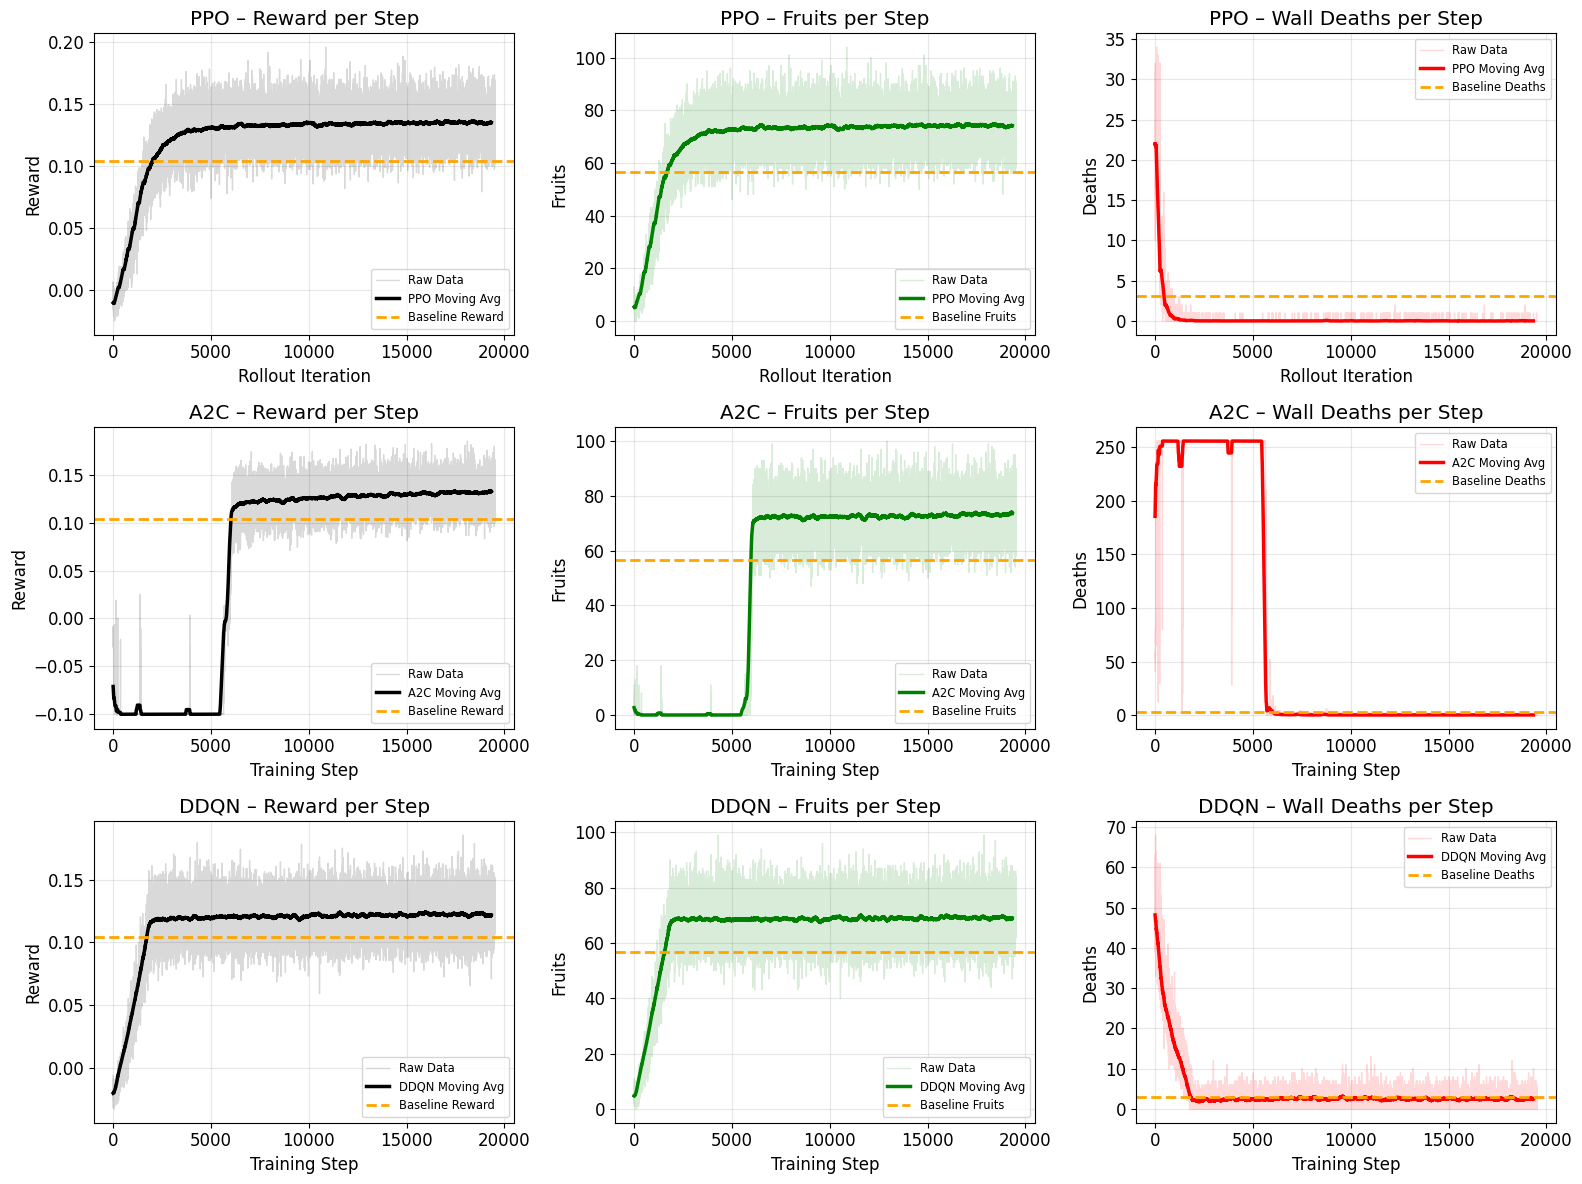

In [23]:
# EVALUATION DURING TRAINING OF PPO AND A2C AGENTS

window = 200
kernel = np.ones(window) / window

# PPO moving averages
ppo_reward_moving = np.convolve(rew_hist, kernel, mode='valid')
ppo_fruits_moving = np.convolve(fruits_hist, kernel, mode='valid')
ppo_deaths_moving = np.convolve(wall_hist, kernel, mode='valid')

# A2C moving averages
a2c_reward_moving = np.convolve(a2c_reward_hist, kernel, mode='valid')
a2c_fruits_moving = np.convolve(a2c_fruits_hist, kernel, mode='valid')
a2c_deaths_moving = np.convolve(a2c_deaths_hist, kernel, mode='valid')

# DDQN moving averages
ddqn_reward_moving = np.convolve(ddqn_rew_hist, kernel, mode='valid')
ddqn_fruits_moving = np.convolve(ddqn_fruits_hist, kernel, mode='valid')
ddqn_deaths_moving = np.convolve(ddqn_deaths_hist, kernel, mode='valid')

plt.figure(figsize=(16, 12))
plt.rcParams.update({'font.size': 12})

# -----------------------------
# ROW 1 — PPO
# -----------------------------

# PPO Reward
plt.subplot(3, 3, 1)
plt.plot(rew_hist, color='black', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(ppo_reward_moving, color='black', linewidth=2.5, label="PPO Moving Avg")
plt.axhline(y=baseline_reward_avg, color='orange', linestyle='--', linewidth=2,
            label="Baseline Reward")
plt.title("PPO – Reward per Step")
plt.xlabel("Rollout Iteration")
plt.ylabel("Reward")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# PPO Fruits
plt.subplot(3, 3, 2)
plt.plot(fruits_hist, color='green', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(ppo_fruits_moving, color='green', linewidth=2.5, label="PPO Moving Avg")
plt.axhline(y=baseline_fruits_avg, color='orange', linestyle='--', linewidth=2,
            label="Baseline Fruits")
plt.title("PPO – Fruits per Step")
plt.xlabel("Rollout Iteration")
plt.ylabel("Fruits")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# PPO Deaths
plt.subplot(3, 3, 3)
plt.plot(wall_hist, color='red', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(ppo_deaths_moving, color='red', linewidth=2.5, label="PPO Moving Avg")
plt.axhline(y=baseline_deaths_avg, color='orange', linestyle='--', linewidth=2,
            label="Baseline Deaths")
plt.title("PPO – Wall Deaths per Step")
plt.xlabel("Rollout Iteration")
plt.ylabel("Deaths")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# -----------------------------
# ROW 2 — A2C
# -----------------------------

# A2C Reward
plt.subplot(3, 3, 4)
plt.plot(a2c_reward_hist, color='black', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(a2c_reward_moving, color='black', linewidth=2.5, label="A2C Moving Avg")
plt.axhline(y=baseline_reward_avg, color='orange', linestyle='--', linewidth=2,
            label="Baseline Reward")
plt.title("A2C – Reward per Step")
plt.xlabel("Training Step")
plt.ylabel("Reward")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# A2C Fruits
plt.subplot(3, 3, 5)
plt.plot(a2c_fruits_hist, color='green', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(a2c_fruits_moving, color='green', linewidth=2.5, label="A2C Moving Avg")
plt.axhline(y=baseline_fruits_avg, color='orange', linestyle='--', linewidth=2,
            label="Baseline Fruits")
plt.title("A2C – Fruits per Step")
plt.xlabel("Training Step")
plt.ylabel("Fruits")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# A2C Deaths
plt.subplot(3, 3, 6)
plt.plot(a2c_deaths_hist, color='red', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(a2c_deaths_moving, color='red', linewidth=2.5, label="A2C Moving Avg")
plt.axhline(y=baseline_deaths_avg, color='orange', linestyle='--', linewidth=2,
            label="Baseline Deaths")
plt.title("A2C – Wall Deaths per Step")
plt.xlabel("Training Step")
plt.ylabel("Deaths")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# -----------------------------
# ROW 3 — DDQN
# -----------------------------
plt.subplot(3, 3, 7)
plt.plot(ddqn_rew_hist, color='black', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(ddqn_reward_moving, color='black', linewidth=2.5, label="DDQN Moving Avg")
plt.axhline(y=baseline_reward_avg, color='orange', linestyle='--', linewidth=2,
            label="Baseline Reward")
plt.title("DDQN – Reward per Step")
plt.xlabel("Training Step")
plt.ylabel("Reward")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# DDQN Fruits
plt.subplot(3, 3, 8)
plt.plot(ddqn_fruits_hist, color='green', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(ddqn_fruits_moving, color='green', linewidth=2.5, label="DDQN Moving Avg")
plt.axhline(y=baseline_fruits_avg, color='orange', linestyle='--', linewidth=2,
            label="Baseline Fruits")
plt.title("DDQN – Fruits per Step")
plt.xlabel("Training Step")
plt.ylabel("Fruits")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

# DDQN Deaths
plt.subplot(3, 3, 9)
plt.plot(ddqn_deaths_hist, color='red', alpha=0.15, linewidth=1, label="Raw Data")
plt.plot(ddqn_deaths_moving, color='red', linewidth=2.5, label="DDQN Moving Avg")
plt.axhline(y=baseline_deaths_avg, color='orange', linestyle='--', linewidth=2,
            label="Baseline Deaths")
plt.title("DDQN – Wall Deaths per Step")
plt.xlabel("Training Step")
plt.ylabel("Deaths")
plt.legend(fontsize='x-small')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Play Snake with PPO Agent

In [ ]:
# Load the trained model
agent = PPOAgent(board_size=7, n_actions=4)
agent.net.load_state_dict(torch.load("ppo_snake_weights.pth"))
agent.net.eval()

In [ ]:
def display_game(model, max_steps=100):
    # Create a single environment for visualization
    game_env = get_env(n=1)
    state = game_env.to_state()
    frames = []

    frames.append(game_env.boards[0].copy())

    print("Generating animation...", end="")

    model.eval()

    for _ in range(max_steps):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device)

        # Safety mask
        mask = get_safety_mask(game_env)

        with torch.no_grad():
            logits, _ = model(state_tensor)
            logits = logits + mask * -1.0
            actions = torch.argmax(logits, dim=1)

        actions_np = actions.cpu().numpy().reshape(-1, 1)

        game_env.move(actions_np)
        state = game_env.to_state()

        frames.append(game_env.boards[0].copy())

    # -----------------------------------------
    # 1. STATIC SNAPSHOTS EVERY 15 STEPS
    # -----------------------------------------
    snapshot_steps = [0, 10, 20, 30, 40]
    snapshot_steps = [s for s in snapshot_steps if s < len(frames)]

    fig, axes = plt.subplots(1, len(snapshot_steps), figsize=(15, 3))

    for ax, step in zip(axes, snapshot_steps):
        ax.imshow(frames[step], origin='lower', cmap='viridis', vmin=0, vmax=4)
        ax.set_title(f"Step {step}")
        ax.axis('off')

    plt.show()

    # -----------------------------------------
    # 2. ANIMATION
    # -----------------------------------------
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.axis('off')

    img = ax.imshow(frames[0], origin='lower', cmap='viridis', vmin=0, vmax=4)
    ax.set_title("Snake Agent Replay")

    def update(frame):
        img.set_array(frame)
        return [img]

    ani = animation.FuncAnimation(
        fig,
        update,
        frames=frames,
        interval=100,
        blit=True
    )

    plt.close()
    return HTML(ani.to_jshtml())


In [ ]:
display_game(agent.net, max_steps=200)